# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [39]:
data = pd.read_csv(
    '/datasets/taxi.csv', index_col=[0], parse_dates=[0]
)
data.shape

(26496, 1)

In [40]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Note: Observations are taken every 10 mins. Data needs to be resampled by 1 hour.


In [41]:
data.isna().sum().sum()

0

In [42]:
# look at minimum and maximum
data.sort_index(inplace=True)
print("Taxi Min:", data.index.min())
print("Taxi Max:", data.index.max())

Taxi Min: 2018-03-01 00:00:00
Taxi Max: 2018-08-31 23:50:00


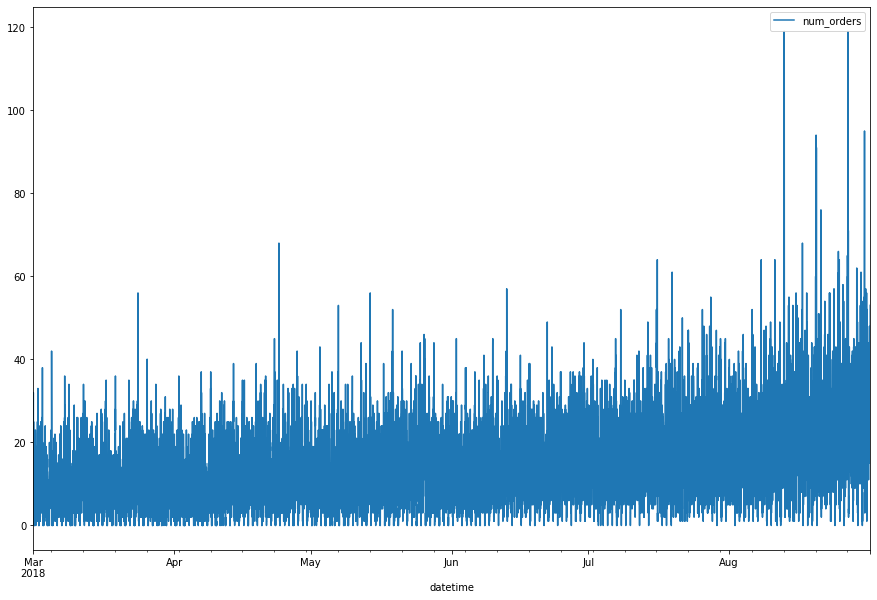

In [43]:
data.plot(figsize=(15, 10))

In [44]:
# resample by 1H and plot
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


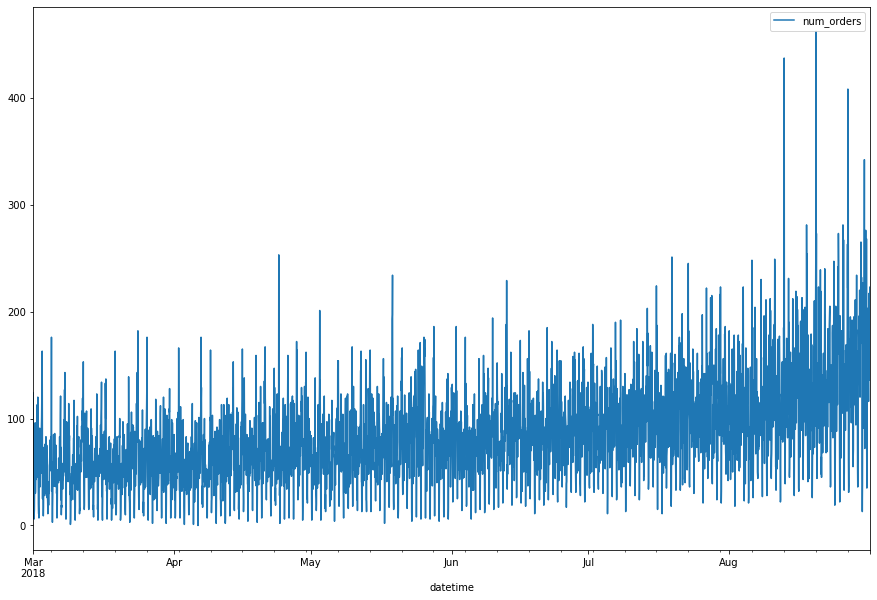

In [45]:
data.plot(figsize=(15,10))

In [46]:
data.shape

(4416, 1)

### Preparation Conclusion

> The data seems to be in order and contains no missing values. On first glance, we see there is an increase in taxi orders in August, but this might be non-stationarity. Let's analyze the data.

## Analysis

Text(0.5, 1.0, 'Trend')

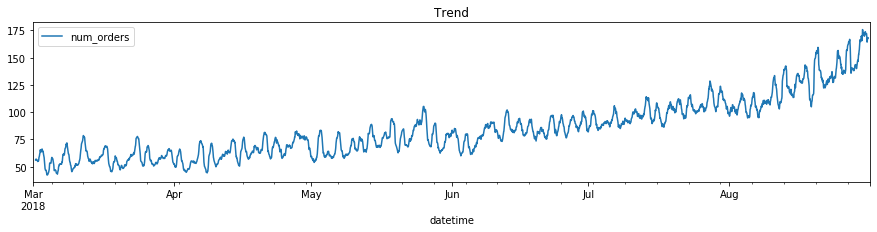

In [47]:
# time to decompose to look at trend, season, resid, and obs
# code taken from lesson
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15,10))
plt.title("Trend")

Text(0.5, 1.0, 'Seasonality')

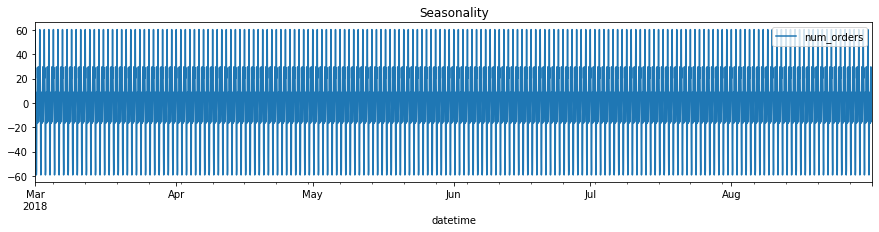

In [48]:
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15,10))
plt.title('Seasonality')

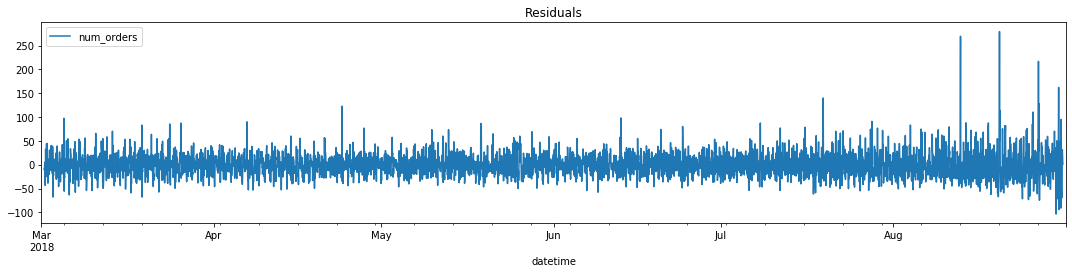

In [49]:
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), figsize=(15,10))
plt.title('Residuals')
plt.tight_layout()

In [50]:
decomposed.seasonal

,num_orders
datetime,
2018-03-01 00:00:00,60.248112
2018-03-01 01:00:00,20.177074
2018-03-01 02:00:00,28.982743
2018-03-01 03:00:00,17.885407
2018-03-01 04:00:00,2.791145
...,...
2018-08-31 19:00:00,-7.124270
2018-08-31 20:00:00,-2.696560
2018-08-31 21:00:00,10.670243


Text(0.5, 1.0, 'Seasonality')

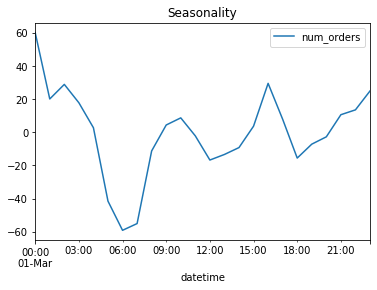

In [51]:
decomposed.seasonal['1 March 2018'].plot(ax=plt.gca())
plt.title('Seasonality')

> Seasonal decomposition is used to look
at the data.The trend graph shows an increment
in mean as time goes on. The seasonality chart
displays the cyclical nature of the data.
With the seasonality data it would be safe
to assume there will be more orders in certain
hours of the day than others. 

## Training

In [52]:
data['hour'] = data.index.hour
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
    
for lag in range(1, 6):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

data['rolling_mean'] = data['num_orders'].shift().rolling(10).mean()

In [53]:
data

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,8,31,4,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,154,20,8,31,4,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,159,21,8,31,4,154.0,136.0,207.0,217.0,197.0,162.9


In [54]:
data = data.dropna()
data.head()

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 10:00:00,64,10,3,1,3,69.0,34.0,15.0,12.0,6.0,52.5
2018-03-01 11:00:00,96,11,3,1,3,64.0,69.0,34.0,15.0,12.0,46.5
2018-03-01 12:00:00,30,12,3,1,3,96.0,64.0,69.0,34.0,15.0,47.6
2018-03-01 13:00:00,32,13,3,1,3,30.0,96.0,64.0,69.0,34.0,43.5
2018-03-01 14:00:00,48,14,3,1,3,32.0,30.0,96.0,64.0,69.0,40.1


In [55]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [56]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 10:00:00 2018-07-28 01:00:00
2018-07-28 02:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [57]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

In [58]:
def rmse(true, pred):
    return mean_squared_error(true, pred) ** 0.5

In [59]:
lr = LinearRegression()
lr.fit(features_train, target_train)

pred_train = lr.predict(features_train)
pred_valid = lr.predict(features_valid)

print("RMSE train:", rmse(target_train, pred_train))
print("RMSE valid", rmse(target_valid, pred_valid))

RMSE train: 29.18903228633541
RMSE valid 40.53908230514036


In [60]:
rf = RandomForestRegressor(n_estimators=250)
rf.fit(features_train, target_train)

pred_train = rf.predict(features_train)
pred_valid = rf.predict(features_valid)

print("RMSE train:", rmse(target_train, pred_train))
print("RMSE valid:", rmse(target_valid, pred_valid))

RMSE train: 7.803244056332634
RMSE valid: 31.83876569383306


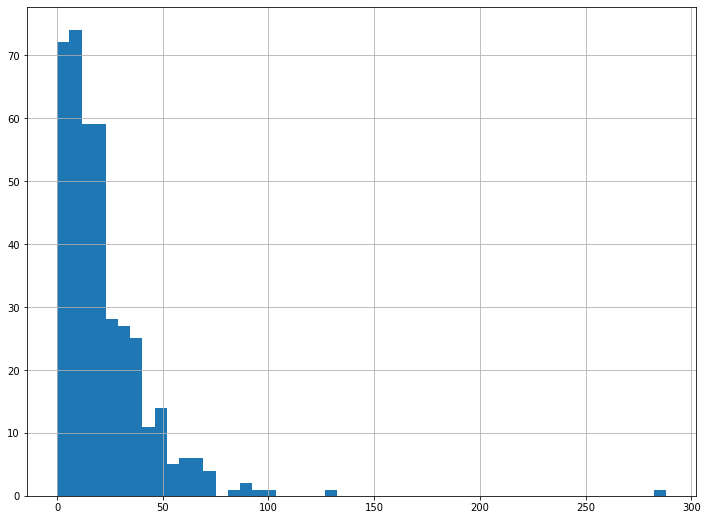

In [61]:
np.abs(target_valid - pred_valid).hist(bins = 50, figsize=(12,9))

The above graph shows the residuals for the valid set. Residual is effectively noise in a data set. Having a residual of zero is ideal! Some days have a residual greater than zero.

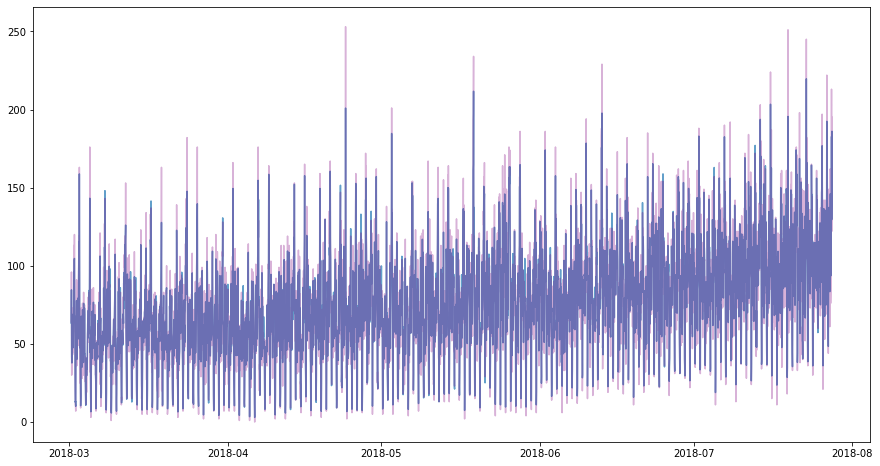

In [62]:
plt.figure(figsize=(15,8))
plt.plot(features_train.index, pred_train, alpha=0.7)
plt.plot(features_train.index, target_train, color='purple', alpha=0.3)

Our predictions are in pink and true values in purple. The high values in pink are what cause the high residuals (in the training set)!

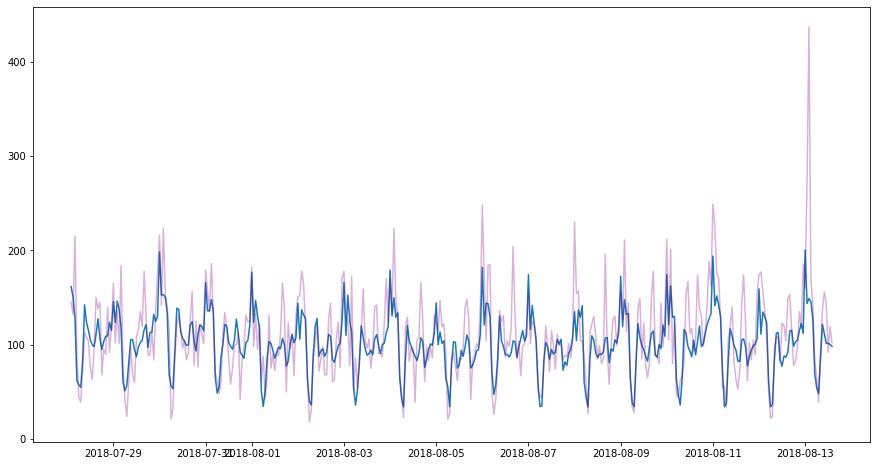

In [63]:
plt.figure(figsize=(15,8))
plt.plot(features_valid.index, pred_valid)
plt.plot(features_valid.index, target_valid, color='purple', alpha=0.3)

The purple line follows the pink line, but they are similar so the model works. 

In [64]:
# more parameter tuning
model = RandomForestRegressor()
params = {
    'n_estimators': [10, 25, 50]
}

tscv = TimeSeriesSplit()
gs = GridSearchCV(estimator=model, cv=tscv, param_grid=params)
gs.fit(train_valid.iloc[:, 1:], train_valid.iloc[:, 0])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=No

In [65]:
gs.cv_results_

{'mean_fit_time': array([0.12470078, 0.29092344, 0.5723203 ]),
 'std_fit_time': array([0.04082304, 0.11665014, 0.22553632]),
 'mean_score_time': array([0.00511742, 0.00852068, 0.01453257]),
 'std_score_time': array([0.00034909, 0.00048812, 0.00102189]),
 'param_n_estimators': masked_array(data=[10, 25, 50],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10}, {'n_estimators': 25}, {'n_estimators': 50}],
 'split0_test_score': array([0.36010435, 0.36296634, 0.36899005]),
 'split1_test_score': array([0.44934419, 0.45362718, 0.46385472]),
 'split2_test_score': array([0.33527283, 0.40504637, 0.41324784]),
 'mean_test_score': array([0.38157379, 0.4072133 , 0.4153642 ]),
 'std_test_score': array([0.04898144, 0.03704384, 0.03875724]),
 'rank_test_score': array([3, 2, 1], dtype=int32)}

In [68]:
gs.best_params_

{'n_estimators': 50}

## Testing

In [69]:
features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

In [70]:
model = RandomForestRegressor(n_estimators=250)
model.fit(features_train_valid, target_train_valid)

pred_train = model.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 8.298919292136915
RMSE test: 46.34792568724305


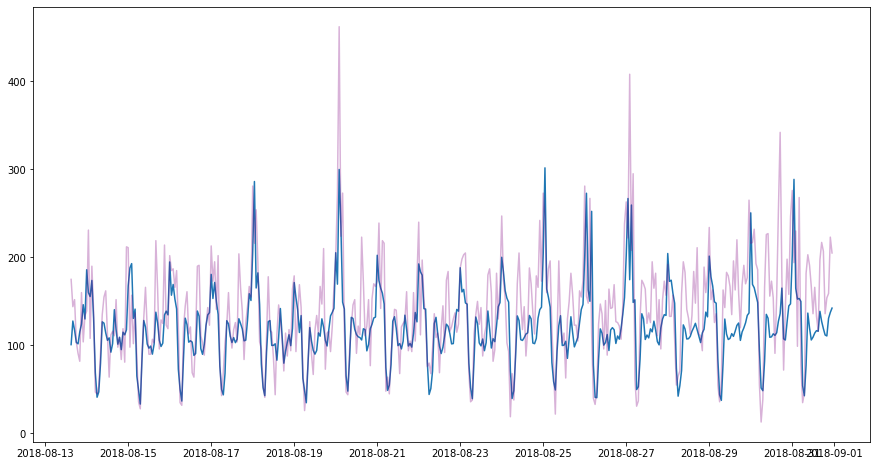

In [71]:
plt.figure(figsize=(15,8))
plt.plot(features_test.index, pred_test)
plt.plot(features_test.index, target_test, color='purple', alpha=0.3)

Toward the end of the month, the trend increases, but our model does not follow that. A possible solution for this is to retrain the model.

In [77]:
# testing using best params

model_bp = RandomForestRegressor(n_estimators=50)
model_bp.fit(features_train_valid, target_train_valid)

pred_train = model_bp.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model_bp.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 8.650432337270189
RMSE test: 47.673126521031215


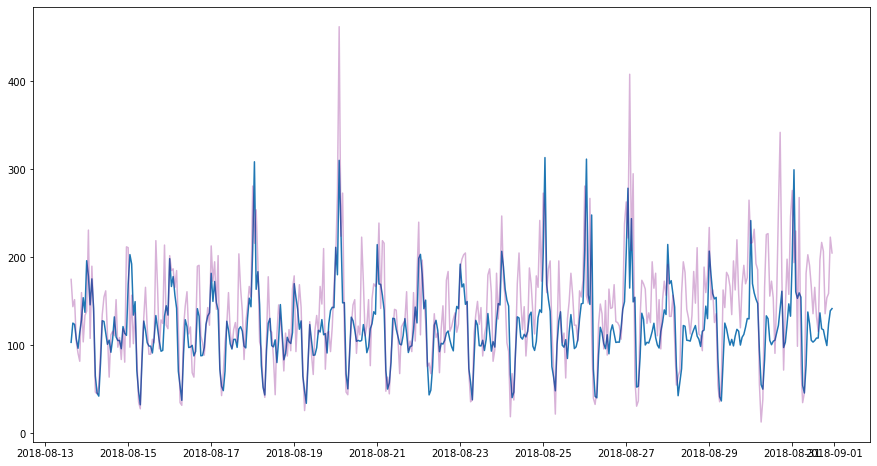

In [78]:
plt.figure(figsize=(15,8))
plt.plot(features_test.index, pred_test)
plt.plot(features_test.index, target_test, color='purple', alpha=0.3)

The result is slightly worse than our original paramater for 250 n_estimators, but it performs better than the Linear Regression model. 

In [72]:
model_lr =LinearRegression()
model_lr.fit(features_train_valid, target_train_valid)

pred_train = model_lr.predict(features_train_valid)
print("RMSE train:", rmse(target_train_valid, pred_train))

pred_test = model_lr.predict(features_test)
print("RMSE test:", rmse(target_test, pred_test))

RMSE train: 30.487844063118892
RMSE test: 53.16140298980907


The Linear Regression Model performs worse on the test set and the RMSE is higher than 48. We will not be using this model.

In [73]:
# grid search - selecting the better model
# CODE FROM WEBINAR
#tscv = TimeSeriesSplit()
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [74]:
for train_index, test_index in tscv.split(train_valid):
#    print("TRAIN:", train_index, "TEST:", test_index)
    print("TRAIN indices: ", train_index[0], ", ",  train_index[-1])
    print("TRAIN time range", train_valid.iloc[train_index].index[0], ", ", train_valid.iloc[train_index].index[-1])
    print("TEST indices: ", test_index[0], ", ",  test_index[-1])
    print("TEST time range", train_valid.iloc[test_index].index[0], ", ", train_valid.iloc[test_index].index[-1])
    print('----------------------------------------------------------------')
    train, valid = train_valid.iloc[train_index], train_valid.iloc[test_index]

TRAIN indices:  0 ,  664
TRAIN time range 2018-03-01 10:00:00 ,  2018-03-29 02:00:00
TEST indices:  665 ,  1324
TEST time range 2018-03-29 03:00:00 ,  2018-04-25 14:00:00
----------------------------------------------------------------
TRAIN indices:  0 ,  1324
TRAIN time range 2018-03-01 10:00:00 ,  2018-04-25 14:00:00
TEST indices:  1325 ,  1984
TEST time range 2018-04-25 15:00:00 ,  2018-05-23 02:00:00
----------------------------------------------------------------
TRAIN indices:  0 ,  1984
TRAIN time range 2018-03-01 10:00:00 ,  2018-05-23 02:00:00
TEST indices:  1985 ,  2644
TEST time range 2018-05-23 03:00:00 ,  2018-06-19 14:00:00
----------------------------------------------------------------
TRAIN indices:  0 ,  2644
TRAIN time range 2018-03-01 10:00:00 ,  2018-06-19 14:00:00
TEST indices:  2645 ,  3304
TEST time range 2018-06-19 15:00:00 ,  2018-07-17 02:00:00
----------------------------------------------------------------
TRAIN indices:  0 ,  3304
TRAIN time range 2018-03

In [75]:
cmap_cv = plt.cm.coolwarm
cmap_data = plt.cm.Paired

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

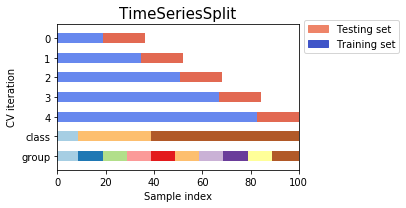

In [76]:
n_splits = 5
# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 10 for ii in range(10)])



this_cv = TimeSeriesSplit(n_splits=n_splits)
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=.7)
plt.show()

## Conclusion

In the end, we use RandomForest Regression and GridSearch to find an ideal model that will predict the amount of taxi orders for the next hour for Sweet Lift Taxi Company.